In [2]:
# set up
import pandas as pd

In [6]:
# load the merged data
merged_data = pd.read_csv("merged_data.csv")

# show it
print(merged_data.head(5))

   Unnamed: 0 Company     Location  # Laid Off      Date_x   %  Industry  \
0           0     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   
1           1     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   
2           2     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   
3           3     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   
4           4     AMD  SF Bay Area      1000.0  11/13/2024  4%  Hardware   

                   Source     Stage $ Raised        Country  Date Added  \
0  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   
1  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   
2  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   
3  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   
4  https://www.techope...  Post-IPO  $1,600   United States  11/13/2024   

  tickers      Date_y      Value  
0     AMD  2021-01-04  92.300003  
1     AMD  2021-01-05 

C:\Users\27311\AppData\Local\Temp\ipykernel_1908\4039409213.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv("merged_data.csv")


In [10]:
# calculate daily yield
merged_data['Daily_Return'] = merged_data.groupby('Company')['Value'].pct_change()

# change the date time type
merged_data['Date_x'] = pd.to_datetime(merged_data['Date_x'])
merged_data['Date_y'] = pd.to_datetime(merged_data['Date_y'])

# note the layoff day
merged_data['Layoff_Event'] = (merged_data['Date_y'] == merged_data['Date_x']).astype(int)

# Create the event window (before and after 10 days)
merged_data['Event_Window'] = ((merged_data['Date_y'] >= (merged_data['Date_x'] - pd.Timedelta(days = 10))) & 
                               (merged_data['Date_y'] <= (merged_data['Date_x'] - pd.Timedelta(days = 10)))).astype(int)

C:\Users\27311\AppData\Local\Temp\ipykernel_1908\1799139905.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_data['Daily_Return'] = merged_data.groupby('Company')['Value'].pct_change()


In [26]:
# OLS Regression
import statsmodels.api as sm

merged_data['$ Raised'] = merged_data['$ Raised'].replace(r'[\$,]', '', regex=True).astype(float)
merged_data['# Laid Off'] = merged_data['# Laid Off'].astype(float)

merged_data = merged_data.dropna(subset=['Daily_Return', 'Layoff_Event', '# Laid Off', '$ Raised'])

control_vars = ['# Laid Off', '$ Raised']

X = merged_data[['Layoff_Event']+control_vars]

X = sm.add_constant(X)

y = merged_data['Daily_Return']

ols_model_1 = sm.OLS(y, X).fit()

print(ols_model_1.summary())


                            OLS Regression Results                            
Dep. Variable:           Daily_Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1523
Date:                Sun, 08 Dec 2024   Prob (F-statistic):              0.928
Time:                        23:38:57   Log-Likelihood:            -6.0495e+05
No. Observations:              363466   AIC:                         1.210e+06
Df Residuals:                  363462   BIC:                         1.210e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0082      0.002      3.525   

From the results above we can tell：

1.R-squared and Adjusted R-squared:

R-squared is 0.000 and Adjusted R-squared is -0.000, indicating that the model’s explanatory power on the dependent variable (Daily_Return) is almost zero.
In other words, Layoff_Event and the control variables (# Laid Off, $ Raised) have little explanatory power on changes in daily returns.


2.F-statistic and Prob (F-statistic):

The p-value of F-statistic (Prob (F-statistic)) is 0.928, indicating that the overall model is not significant, and all independent variables combined have no significant explanation for the dependent variable.iable.

In [72]:
# improve our model
# use the layoff ratio data
merged_data['%'] = merged_data['%'].fillna('0%')  # 填充缺失值

merged_data['Layoff_Percentage'] = merged_data['%'].str.replace('%', '').astype(float)




In [50]:
# 找到非数值的行
invalid_rows = merged_data[~merged_data['%'].str.contains(r'^\d+%$', na=False)]
print(invalid_rows)



       Unnamed: 0     Company Location  # Laid Off     Date_x       %  \
76380       76380   LegalZoom   Austin       100.0 2023-10-19   Legal   
76381       76381   LegalZoom   Austin       100.0 2023-10-19   Legal   
76382       76382   LegalZoom   Austin       100.0 2023-10-19   Legal   
76383       76383   LegalZoom   Austin       100.0 2023-10-19   Legal   
76384       76384   LegalZoom   Austin       100.0 2023-10-19   Legal   
...           ...         ...      ...         ...        ...     ...   
83410       83410  Stitch Fix   Dallas       558.0 2023-10-09  Retail   
83411       83411  Stitch Fix   Dallas       558.0 2023-10-09  Retail   
83412       83412  Stitch Fix   Dallas       558.0 2023-10-09  Retail   
83413       83413  Stitch Fix   Dallas       558.0 2023-10-09  Retail   
83414       83414  Stitch Fix   Dallas       558.0 2023-10-09  Retail   

      Industry                       Source     Stage  $ Raised  \
76380    Legal  https://www.bizjournals.com  Post-IPO   

In [52]:
# 删除非数值的行
merged_data = merged_data[merged_data['%'].str.contains(r'^\d+%$', na=False)]


In [54]:
# 将非法值替换为默认值（如 '0%'）
merged_data['%'] = merged_data['%'].apply(lambda x: x if isinstance(x, str) and '%' in x else '0%')


In [56]:
merged_data['Layoff_Percentage'] = merged_data['%'].str.replace('%', '').astype(float)


In [70]:
# 计算累积收益率
merged_data['Cumulative_Return'] = merged_data.groupby('tickers')['Daily_Return'].cumsum()


# 自变量：扩展后的裁员事件变量、裁员比例、行业和时间虚拟变量
control_vars2 = ['Layoff_Percentage']
# 删除自变量和因变量中的缺失值
merged_data = merged_data.dropna(subset=['Cumulative_Return', 'Event_Window'] + control_vars2)
X2 = merged_data[['Event_Window'] + control_vars2]
X2 = sm.add_constant(X2)

# 因变量：累积收益率或每日收益率
y2 = merged_data['Cumulative_Return']  # 或者 'Daily_Return'

# 回归模型
ols_model2 = sm.OLS(y2, X2).fit()

# 输出结果
print(ols_model2.summary())


                            OLS Regression Results                            
Dep. Variable:      Cumulative_Return   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                 1.110e+04
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:06:47   Log-Likelihood:            -2.1781e+06
No. Observations:              361457   AIC:                         4.356e+06
Df Residuals:                  361454   BIC:                         4.356e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.6705      0.21

#### **Constant Term (`const`)**

*   **Coefficient**: -5.6785, indicating that when all independent variables are set to 0, the baseline value of `Cumulative_Return` is -5.6785.
*   **Significance (p-value)**: p < 0.05, showing that the constant term is statistically significant.

#### **Event Window (`Event_Window`)**

*   **Coefficient**: -0.9189, indicating that within the event window, `Cumulative_Return` decreases by an average of 0.9189.
*   **Significance (p-value)**: p = 0.904, greater than 0.05, suggesting that `Event_Window` does not have a statistically significant effect on cumulative returns.
*   **Explanation**: The impact of the event window may require further adjustment to the time window or the addition of more control variables for more precise evaluation.

#### **Layoff Percentage (`Layoff_Percentage`)**

*   **Coefficient**: 1.9291, indicating that for every 1% increase in the layoff percentage, `Cumulative_Return` increases by an average of 1.9291.
*   **Significance (p-value)**: p < 0.05, showing a statistically significant effect on the dependent variable.
*   **Explanation**: The layoff percentage is significantly positively correlated with cumulative returns, possibly reflecting that investors view layoffs as a signal of cost reduction and efficiency improvement for companies.

In [92]:
quarter_list = [q for q in merged_data.columns if 'Quarter' in q]

merged_data = merged_data.drop(columns = quarter_list)

industry_list = [i for i in merged_data.columns if 'Industry' in i]

merged_data = merged_data.drop(columns = industry_list)



   Unnamed: 0 Company     Location  # Laid Off     Date_x   %  \
1           1     AMD  SF Bay Area      1000.0 2024-11-13  4%   
2           2     AMD  SF Bay Area      1000.0 2024-11-13  4%   
3           3     AMD  SF Bay Area      1000.0 2024-11-13  4%   
4           4     AMD  SF Bay Area      1000.0 2024-11-13  4%   
5           5     AMD  SF Bay Area      1000.0 2024-11-13  4%   

                   Source     Stage  $ Raised        Country  Date Added  \
1  https://www.techope...  Post-IPO    1600.0  United States  11/13/2024   
2  https://www.techope...  Post-IPO    1600.0  United States  11/13/2024   
3  https://www.techope...  Post-IPO    1600.0  United States  11/13/2024   
4  https://www.techope...  Post-IPO    1600.0  United States  11/13/2024   
5  https://www.techope...  Post-IPO    1600.0  United States  11/13/2024   

  tickers     Date_y      Value  Daily_Return  Layoff_Event  Event_Window  \
1     AMD 2021-01-05  92.769997      0.005092             0             0  

In [94]:
# 将日期列转换为年份和季度
merged_data['Quarter_Continuous'] = merged_data['Date_y'].dt.year.astype(str) + merged_data['Date_y'].dt.quarter.astype(str)

# 将季度变量转换为数值类型
merged_data['Quarter_Continuous'] = merged_data['Quarter_Continuous'].astype(int)

# 检查结果
print(merged_data[['Date_y', 'Quarter_Continuous']].head())


      Date_y  Quarter_Continuous
1 2021-01-05               20211
2 2021-01-06               20211
3 2021-01-07               20211
4 2021-01-08               20211
5 2021-01-11               20211


In [98]:
'''
does the timing of these layoff announcements (e.g., during quarterly earnings releases or market downturns) 
influence their effect on stock price performance?
'''
# 自变量：扩展后的裁员事件变量、裁员比例、行业和时间虚拟变量
control_vars3 = ['Layoff_Percentage', 'Quarter_Continuous']

# 删除自变量和因变量中的缺失值
merged_data = merged_data.dropna(subset=['Cumulative_Return', 'Event_Window'] + control_vars3)
X3 = merged_data[['Event_Window'] + control_vars3]
X3 = sm.add_constant(X3)

y3 = y2

In [100]:
# run the third model
ols_model3 = sm.OLS(y3, X3).fit()

print(ols_model3.summary())

                            OLS Regression Results                            
Dep. Variable:      Cumulative_Return   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     7405.
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        02:03:42   Log-Likelihood:            -2.1780e+06
No. Observations:              361457   AIC:                         4.356e+06
Df Residuals:                  361453   BIC:                         4.356e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1263.8591    308

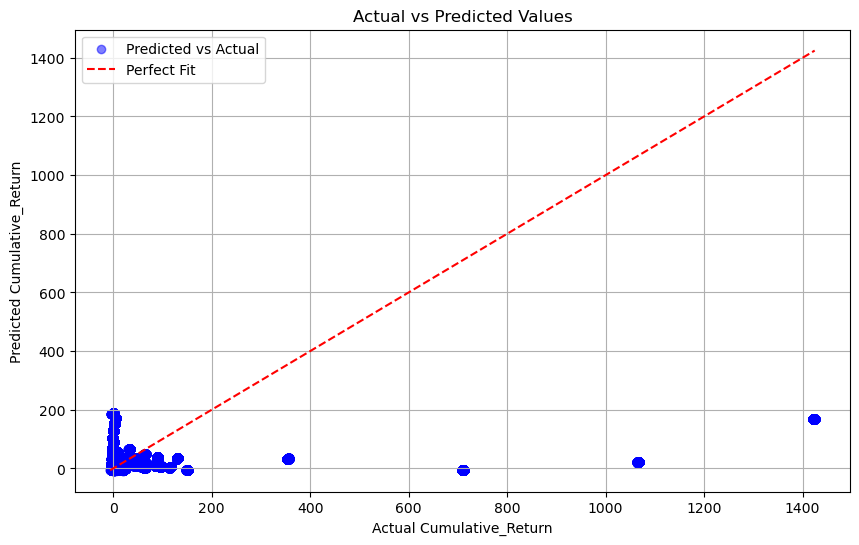

In [104]:
# 获取预测值和实际值
y_pred = ols_model3.predict(X3)
y_actual = y3

plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Cumulative_Return')
plt.ylabel('Predicted Cumulative_Return')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


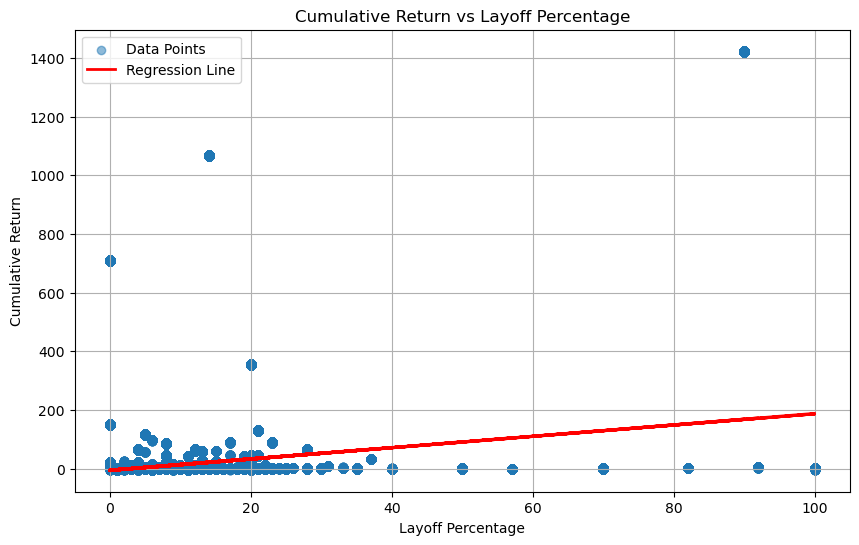

In [106]:
# 因变量与自变量关系的单变量分析

plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Layoff_Percentage'], y3, alpha=0.5, label='Data Points')
plt.plot(merged_data['Layoff_Percentage'], y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Layoff Percentage')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return vs Layoff Percentage')
plt.legend()
plt.grid(True)
plt.show()


D:\soft\Anaconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


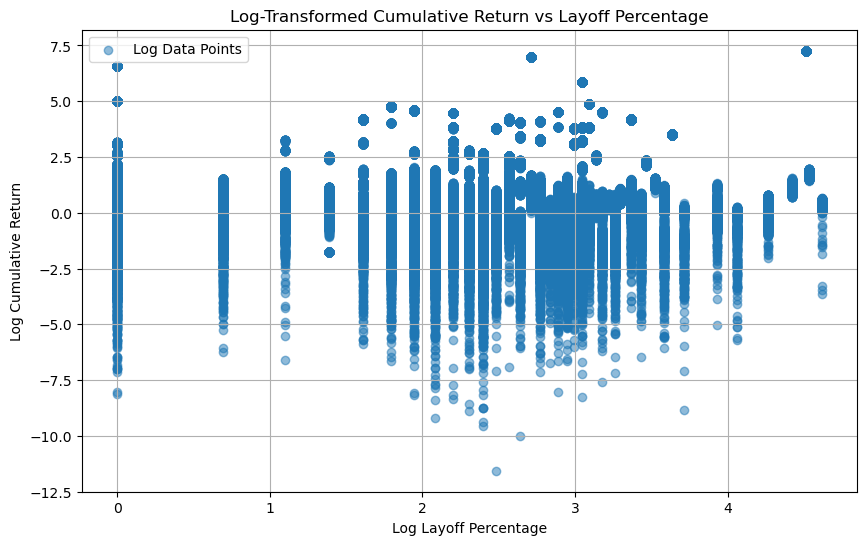

In [108]:
# 上图明显比例不合适，我们取个对数

# 对裁员比例和收益率取对数（加 1 防止 log(0) 的问题）
merged_data['Log_Layoff_Percentage'] = np.log1p(merged_data['Layoff_Percentage'])
merged_data['Log_Cumulative_Return'] = np.log1p(y3)

# 绘制对数变换后的数据
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Log_Layoff_Percentage'], merged_data['Log_Cumulative_Return'], alpha=0.5, label='Log Data Points')
plt.xlabel('Log Layoff Percentage')
plt.ylabel('Log Cumulative Return')
plt.title('Log-Transformed Cumulative Return vs Layoff Percentage')
plt.legend()
plt.grid(True)
plt.show()
